# Neural Network Basic Example 

#### Learning how to classify iris flowers based on a vector of features

Imports

In [12]:
import deeplib
from deeplib.models import Model, Trainer
from deeplib.layers import Dense, Softmax, Relu
from deeplib.utils import split_dataset, DataLoader, one_hot_encode
from deeplib.losses import CrossEntropyLoss, MeanAbsoluteError
from deeplib.optimizers import GD

import numpy as np
import pandas as pd

In [13]:
# Training
epochs = 20
batch_size = 2
learning_rate = 0.001
val_split = 0.2
test_split = 0.2

Load Data

In [14]:
dataset = pd.read_csv('./data/iris_flowers.csv')
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,iris_setosa
1,4.9,3.0,1.4,0.2,iris_setosa
2,4.7,3.2,1.3,0.2,iris_setosa
3,4.6,3.1,1.5,0.2,iris_setosa
4,5.0,3.6,1.4,0.2,iris_setosa


In [15]:
y_df = dataset['class']
X_df = dataset.drop('class', axis=1)
num_features = len(X_df.columns)
num_classes = y_df.nunique()
X = X_df.values
y = y_df.values
y = one_hot_encode(y)
print("Samples:", len(y))
print("Num Classes:", num_classes)
print("Num Features:", num_features)

Samples: 150
Num Classes: 3
Num Features: 4


In [16]:
X_df.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Normalize values

In [17]:
for i in range(len(X)):
    array = X[i]
    X[i, :] = (array - np.min(array)) / (np.max(array) - np.min(array))
print(X.shape)
print(np.max(X), np.min(X))

(150, 4)
1.0 0.0


Split into train and test

In [18]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
    split_dataset(X, y, test_split=test_split, val_split=val_split, shuffle=True)
print("Training Samples:", len(X_train))
print("Validation Samples:", len(X_val))
print("Test Samples:", len(X_test))

Training Samples: 96
Validation Samples: 24
Test Samples: 30


Define Model Architecture

In [19]:
class MultiLayerPerceptron(Model):
    
    def __init__(self) -> None:
        super().__init__()
        input_size = num_features
        output_size = num_classes

        self.add(Dense(input_size, 4))
        self.add(Relu())
        self.add(Dense(4, 3))
        self.add(Relu())
        self.add(Dense(3, output_size))
        #self.add(Softmax())

Train the model

In [20]:
model = MultiLayerPerceptron()

trainer = Trainer(model)
train_loader = DataLoader(X_train, y_train, batch_size=batch_size)
validation_loader = DataLoader(X_val, y_val, batch_size=len(X_val))
loss_fn = MeanAbsoluteError()
optimizer = GD(model, lr=0.001)
history = trainer.fit(train_loader, epochs, loss_fn, optimizer, show_pbar=False)

EPOCH 1/20 loss: 0.2716540162458138 accuracy: 0.0

EPOCH 2/20 loss: 0.24723532222657277 accuracy: 0.0

EPOCH 3/20 loss: 0.23851058593880994 accuracy: 0.0

EPOCH 4/20 loss: 0.23166745226384455 accuracy: 0.0

EPOCH 5/20 loss: 0.2261111091431892 accuracy: 0.0

EPOCH 6/20 loss: 0.2218237769590317 accuracy: 0.0

EPOCH 7/20 loss: 0.2182288848609489 accuracy: 0.0

EPOCH 8/20 loss: 0.2151270465089573 accuracy: 0.0

EPOCH 9/20 loss: 0.2126877802637759 accuracy: 0.0

EPOCH 10/20 loss: 0.210864868324806 accuracy: 0.0

EPOCH 11/20 loss: 0.2093775649074825 accuracy: 0.0

EPOCH 12/20 loss: 0.20804667341020952 accuracy: 0.0

EPOCH 13/20 loss: 0.20698743943071488 accuracy: 0.0

EPOCH 14/20 loss: 0.2059423014120159 accuracy: 0.0

EPOCH 15/20 loss: 0.20514391832254883 accuracy: 0.0

EPOCH 16/20 loss: 0.20448971115946257 accuracy: 0.0

EPOCH 17/20 loss: 0.2038896634092281 accuracy: 0.0

EPOCH 18/20 loss: 0.2033548432543131 accuracy: 0.0

EPOCH 19/20 loss: 0.2028416314773007 accuracy: 0.0

EPOCH 20/20 los

Show Training History 

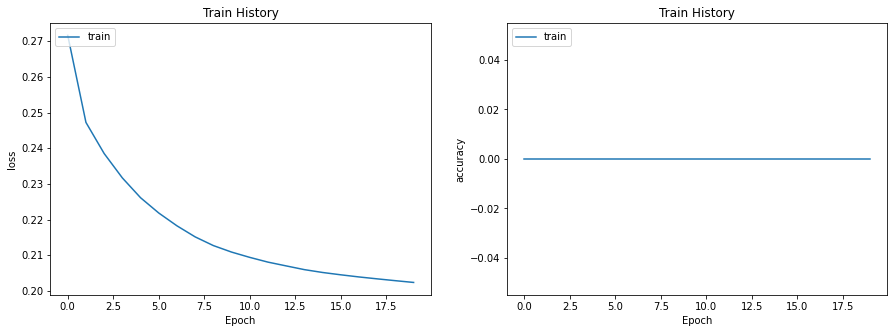

In [21]:
trainer.plot(metrics=['loss', 'accuracy'])

Test model performance on hold out data

In [22]:
# trainer.test()